# Model Evaluation

Here we will work with Credit Card Data from "Econometric Analysis"

- We will create classification model
- Then we will inspect the output of different evaluation metrics

In [75]:
import pandas as pd
import numpy as np

from collections import Counter

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

In [76]:
# load data:
df = pd.read_csv('./AER_credit_card_data.csv')
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


target variable - "card"
- this feature is binary

# Data Preparation

- We will change target variable coding:
    - yes = 1
    - no = 0
- Then we will split data into 3 parts (train/validation/test) with 60/20/20% share

In [77]:
# mapping target variable:
def target_variable_mapping(value):
    if value == 'yes':
        result = 1
    elif value == 'no':
        result = 0
    return result

# apply mapping:
df['card'] = df['card'].apply(lambda x: target_variable_mapping(x))
df_initial = df.copy()

In [78]:
# data splitting:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [79]:
# check:
n = len(df)
n_train = len(df_train)
n_val = len(df_val)
n_test = len(df_test)


print(f'n_train = {n_train}')
print(f'n_val = {n_val}')
print(f'n_test = {n_test}')
print(f'Total number of records = {n}')
print(f'test sum = {n_train + n_val + n_test}')

n_train = 791
n_val = 264
n_test = 264
Total number of records = 1319
test sum = 1319


# Question 1:  

AUC could also be used to evaluate feature importance of numerical variables, let us show this

- for each numerical variable, we will use AUC with card variable (target), we will use training dataset for that

- If AUC score < 0.5, we will invert this variable ("negative sign"). AUC score < 0.5 means that there is a negative correlation of studied variable with the target variable

In [80]:
df.dtypes

card             int64
reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
dtype: object

<AxesSubplot:xlabel='dependents', ylabel='card'>

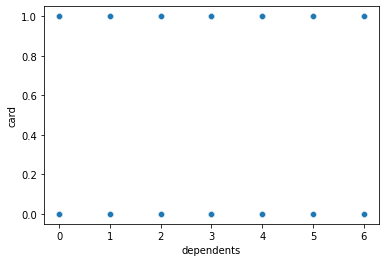

In [81]:
# plot:
sns.scatterplot(data=df_train, x='dependents', y='card')

In [82]:
df_train.sort_values(by='dependents')

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
1203,0,2,24.58333,2.2000,0.000545,0.00000,no,no,0,6,1,8
516,1,0,32.08333,2.4000,0.142641,285.28250,yes,no,0,96,0,8
1010,1,0,61.58333,3.7500,0.000320,0.00000,yes,no,0,288,1,5
1055,1,0,30.58333,1.8000,0.019899,29.51583,no,no,0,6,1,10
1178,1,0,32.00000,2.2800,0.067360,127.98330,yes,no,0,48,0,15
...,...,...,...,...,...,...,...,...,...,...,...,...
1047,1,0,34.83333,3.0000,0.126377,315.94250,no,no,6,12,0,16
851,1,0,34.58333,7.0000,0.035465,206.38170,no,yes,6,63,1,3
815,1,0,43.33333,3.9495,0.157147,517.21170,yes,no,6,3,0,0
1184,0,0,35.83333,4.5000,0.000267,0.00000,yes,no,6,6,0,0


In [83]:
def scores_by_feature(feature):
    scores = []

    thresholds = np.linspace(df_train[feature].min(), df_train[feature].max(), 101)

    for t in thresholds:
        actual_positive = (df_train['card'] == 1)
        actual_negative = (df_train['card'] == 0)
        predict_positive = (df_train[feature] >= t)
        predict_negative = (df_train[feature] < t)
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        scores.append((t, tp, fp, fn, tn))
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    df_scores['tpr'] = df_scores['tp'] / (df_scores['tp']+df_scores['fn'])
    df_scores['fpr'] = df_scores['fp'] / (df_scores['fp']+df_scores['tn'])
    return df_scores

auc_reports = 0.28333701393106236
auc_dependents = 0.46719667273965293
auc_active = 0.6043173411362005
auc_share = 0.9552117263843648


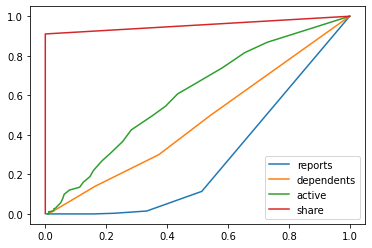

In [84]:
df_scores_reports = scores_by_feature('reports')
df_scores_dependents = scores_by_feature('dependents')
df_scores_active = scores_by_feature('active')
df_scores_share = scores_by_feature('share')

auc_reports = auc(df_scores_reports['fpr'], df_scores_reports['tpr'])
auc_dependents = auc(df_scores_dependents['fpr'], df_scores_dependents['tpr'])
auc_active = auc(df_scores_active['fpr'], df_scores_active['tpr'])
auc_share = auc(df_scores_share['fpr'], df_scores_share['tpr'])

# visualiza one example
plt.plot(df_scores_reports['fpr'], df_scores_reports['tpr'], label='reports')
plt.plot(df_scores_dependents['fpr'], df_scores_dependents['tpr'], label='dependents')
plt.plot(df_scores_active['fpr'], df_scores_active['tpr'], label='active')
plt.plot(df_scores_share['fpr'], df_scores_share['tpr'], label='share')
plt.legend()

print(f'auc_reports = {auc_reports}')
print(f'auc_dependents = {auc_dependents}')
print(f'auc_active = {auc_active}')
print(f'auc_share = {auc_share}')

since only auc score for share feature has value > 0.5, other features will be changed in direction (- sign)

In [85]:
def scores_by_feature_neg(feature):
    scores = []

    thresholds = np.linspace(df_train[feature].min(), df_train[feature].max(), 101)

    for t in thresholds:
        actual_positive = (df_train['card'] == 1)
        actual_negative = (df_train['card'] == 0)
        predict_positive = (df_train[feature] < t)
        predict_negative = (df_train[feature] >= t)
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        scores.append((t, tp, fp, fn, tn))
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    df_scores['tpr'] = df_scores['tp'] / (df_scores['tp']+df_scores['fn'])
    df_scores['fpr'] = df_scores['fp'] / (df_scores['fp']+df_scores['tn'])
    return df_scores

auc_reports = 0.7110132685548134
auc_dependents = 0.5215038922320985
auc_active = 0.6043173411362005
auc_share = 0.9552117263843648


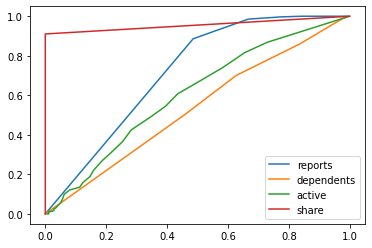

In [86]:
df_scores_reports = scores_by_feature_neg('reports')
df_scores_dependents = scores_by_feature_neg('dependents')
df_scores_active = scores_by_feature('active')
df_scores_share = scores_by_feature('share')

auc_reports = auc(df_scores_reports['fpr'], df_scores_reports['tpr'])
auc_dependents = auc(df_scores_dependents['fpr'], df_scores_dependents['tpr'])
auc_active = auc(df_scores_active['fpr'], df_scores_active['tpr'])
auc_share = auc(df_scores_share['fpr'], df_scores_share['tpr'])

# visualiza
plt.plot(df_scores_reports['fpr'], df_scores_reports['tpr'], label='reports')
plt.plot(df_scores_dependents['fpr'], df_scores_dependents['tpr'], label='dependents')
plt.plot(df_scores_active['fpr'], df_scores_active['tpr'], label='active')
plt.plot(df_scores_share['fpr'], df_scores_share['tpr'], label='share')
plt.legend()

print(f'auc_reports = {auc_reports}')
print(f'auc_dependents = {auc_dependents}')
print(f'auc_active = {auc_active}')
print(f'auc_share = {auc_share}')

**Share** feature has very high AUC score, since

### Training the model

# Question 2

In this porject we will use the following features:
- reports,
- age,
- income,
- share,
- expenditure,
- dependents,
- months,
- majorcards,
- active,
- owner,
- selfemp

In [87]:
df = df[[
    "reports",
     "age",
    "income",
    "share",
    "expenditure",
    "dependents",
    "months",
    "majorcards",
    "active",
    "owner",
    "selfemp",
    'card' # target
    ]]

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_full_train = df_full_train['card'].values
y_train = df_train['card'].values
y_val = df_val['card'].values
y_test = df_test['card'].values

del df_full_train['card']
del df_train['card']
del df_val['card']
del df_test['card']

we will apply one-hot encoding by using DictVectorizer,  
then we will train Logistic Regression model with the following parameters:  
*LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)*

In [88]:
# one-hot encoding of categorical varibales:
dicts_train = df_train.to_dict(orient='records')
dicts_val = df_val.to_dict(orient='records')
dicts_test = df_test.to_dict(orient='records')


dv = DictVectorizer(sparse=False)
dv.fit(dicts_train)
x_train = dv.transform(dicts_train)
x_val = dv.transform(dicts_val)
x_test = dv.transform(dicts_test)

In [89]:
# training the model:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(x_train, y_train)
y_pred_probs = model.predict_proba(x_val)[:,1]
round(roc_auc_score(y_val, y_pred_probs), 3)

0.995

# Question 3

now we will evaluate precision and recall for our model

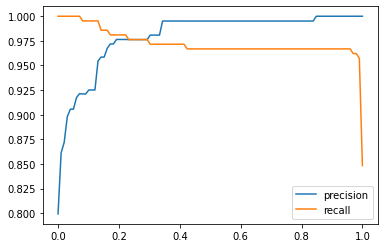

In [90]:
thresholds = np.linspace(0,1, 100)
scores = []
for t in thresholds:

    positive_predictions = y_pred_probs >= t
    negative_predictions = y_pred_probs < t

    positive_actual = y_val == 1
    negative_actual = y_val == 0

    tp = (positive_predictions & positive_actual).sum()
    fp = (positive_predictions & negative_actual).sum()
    tn = (negative_predictions & negative_actual).sum()
    fn = (negative_predictions & positive_actual).sum()
    score = (t, tp, fp, tn, fn)
    scores.append(score)
columns = ['threshold', 'tp', 'fp', 'tn', 'fn']
df_scores = pd.DataFrame(scores, columns = columns)
df_scores['precision'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fp'])
df_scores['recall'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fn'])
df_scores['fpr'] = df_scores['fp'] / (df_scores['tn'] + df_scores['fp'])
df_scores['tpr'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fn'])

# plot
plt.plot(df_scores['threshold'], df_scores['precision'], label='precision')
plt.plot(df_scores['threshold'], df_scores['recall'], label='recall')
plt.legend()


Intercept is on t = 0.3

# Question 4

Precision and Recall are conflicting - when one grows, the other goes down.  
That is why they are often combined into F1 score - metrics that takes both into account

F1 score:  
$$ F1 = \frac{2PR}{P+R} $$

now we will compute F1 score for all thresholds

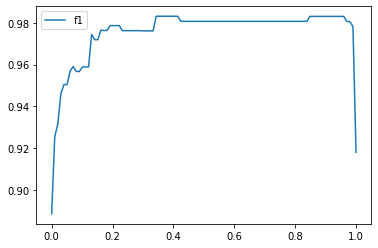

In [91]:
df_scores['f1'] = 2 * df_scores['precision'] * df_scores['recall']\
                  / (df_scores['precision'] + df_scores['recall'])

# plot
plt.plot(df_scores['threshold'], df_scores['f1'], label='f1')
plt.legend()

The highest Value of F1 score is at Threshold = 0.4

# Question 5

Now we will use Kfold class from Scikit-Learn to evaluate our model on 5 different folds:
- Iterate over different folds of full_train dataset
- split data into train and validation
- train the model on train with following parameters of model:
    - *LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)*
- Use AUC score to evaluate the model on validation

In [123]:
# one-hot encodig:
dicts_full_train = df_full_train.to_dict(orient='records')
X_full_train = dv.transform(dicts_full_train)
roc_auc_scores_list = []

# cross validation:
kfolds = KFold(n_splits=5, shuffle=True, random_state=1)
for train_index, val_index in kfolds.split(df_full_train):
    X_train, X_val = X_full_train[train_index], X_full_train[val_index]
    y_train, y_val = y_full_train[train_index], y_full_train[val_index]
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    roc_auc_iter = roc_auc_score(y_val, y_pred)
    print(f'roc_auc_score = {roc_auc_iter}')
    roc_auc_scores_list.append(roc_auc_iter)

roc_auc_std_5_folds = np.array(roc_auc_scores_list).std()
roc_auc_std_rounded = round(roc_auc_std_5_folds, )
print()
print(f'Standard Deviation on 5 kfolds = {roc_auc_std_rounded}')

roc_auc_score = 0.9675387596899225
roc_auc_score = 0.984375
roc_auc_score = 0.9739789196310935
roc_auc_score = 0.9908536585365854
roc_auc_score = 1.0

Standard Deviation on 5 kfolds = 0.012


# Question 6

Now we will use 5-Fold cross-validation to find the best Parameter **C**
- Iterate over the following C values: [0.01, 0.1, 1, 10]
- Initialize KFold with the same parameters as previously
- Use the same model
- Compute the mean score as well as STD

In [126]:
# C parameter tuning using cross-validation
C_test_list = [0.01, 0.1, 1, 10]

for C_test in C_test_list:
    roc_auc_scores_list = []
    kfolds = KFold(n_splits=5, shuffle=True, random_state=1)
    for train_index, val_index in kfolds.split(df_full_train):
        X_train, X_val = X_full_train[train_index], X_full_train[val_index]
        y_train, y_val = y_full_train[train_index], y_full_train[val_index]
        model = LogisticRegression(solver='liblinear', C=C_test, max_iter=1000)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        roc_auc_iter = roc_auc_score(y_val, y_pred)
        roc_auc_scores_list.append(roc_auc_iter)
        roc_auc_scores_array = np.array(roc_auc_scores_list)
        roc_auc_mean = round(roc_auc_scores_array.mean(), 3)
        roc_auc_std = round(roc_auc_scores_array.std(), 3)

    print(f'C = {C_test}, mean_auc = {roc_auc_mean}, std_auc = {roc_auc_std}')

C = 0.01, mean_auc = 0.987, std_auc = 0.007
C = 0.1, mean_auc = 0.985, std_auc = 0.01
C = 1, mean_auc = 0.983, std_auc = 0.012
C = 10, mean_auc = 0.978, std_auc = 0.014


C = 0.01 has highest score and lowest deviation (model is more stable)